In [2]:
import pandas as pd
import numpy as np
import math
from matplotlib import pyplot as plt
import os
import sys
import pickle
# Add the function directory to the path
sys.path.append('/home/jiarong/research/postprocessing/jupyter_notebook/functions/')
from Slicing import Slicing
from fio import readin
from TurStat import TurStat
from tqdm import tqdm

In [156]:
from matplotlib import rc
# text and font
## small, medium, large, x-large, xx-large, larger, or smaller
rc('font',**{'family':'serif','serif':['Palatino']})
rc('text', usetex=True)
plt.rcParams['text.latex.preamble'] = [r'\boldmath']
plt.rcParams['font.size'] = 20
plt.rcParams['axes.labelsize'] = 'large'
plt.rcParams['axes.titlesize'] = 'large'
plt.rcParams['xtick.labelsize'] = 'medium'
plt.rcParams['ytick.labelsize'] = 'medium'
plt.rcParams['legend.fontsize'] = 'small'
# Figure size
plt.rcParams['figure.figsize'] = 8, 4.8 ## figure size in inches
plt.rcParams['figure.dpi'] = 1200        ## figure dots per inchfigsize : 6.4, 4.8
# Line
plt.rcParams['lines.linewidth'] = 2
plt.rcParams['lines.markersize'] = 10
# Ticks
plt.rcParams['xtick.minor.visible'] = False
plt.rcParams['xtick.major.size'] = 3.5

In [18]:
def shape_input(N, snapshot):
    x = np.reshape(np.array(snapshot.x), (N,N,N))
    y = np.reshape(np.array(snapshot.y), (N,N,N))
    z = np.reshape(np.array(snapshot.z), (N,N,N))
    ux = np.reshape(np.array(snapshot['u.x']), (N,N,N))
    uy = np.reshape(np.array(snapshot['u.y']), (N,N,N))
    uz = np.reshape(np.array(snapshot['u.z']), (N,N,N))
#     Evis = np.reshape(np.array(snapshot['Evis']), (N,N,N))
    dudy = np.reshape(np.array(snapshot['dudy']), (N,N,N))
    p = np.reshape(np.array(snapshot['p']), (N,N,N))
    gx = np.reshape(np.array(snapshot['g.x']), (N,N,N))
    return x,y,z,ux,uy,uz,dudy,p,gx

In [128]:
filename = "/home/jiarong/research/projects/LES/fflat_LES_withforcing/field_600"
snapshot = pd.read_table(filename, delimiter = ',')
# Sort dataframe by y value, only taking the upper half, optional
snapshot = snapshot.sort_values(by = ['x','y','z'])
x,y,z,ux,uy,Evis,dudy,p,gx = shape_input(32,snapshot)
# ux1=ux
# gx1=gx
# filename = "/home/jiarong/research/projects/LES/fisotropicLES/field_2"
# snapshot = pd.read_table(filename, delimiter = ',')
# # Sort dataframe by y value, only taking the upper half, optional
# snapshot = snapshot.sort_values(by = ['x','y','z'])
# x,y,z,ux,uy,Evis,dudy,p,gx = shape_input(32,snapshot)
# ux2=ux
# gx2=gx

In [119]:
from mpl_toolkits.axes_grid1 import ImageGrid
def contour_generator():
    fig = plt.figure(figsize=(10,4))
    grid = ImageGrid(fig, 111,          # as in plt.subplot(111)
                     nrows_ncols=(1,1),
                     axes_pad=0.15,
                     share_all=True,
                     cbar_location="right",
                     cbar_mode="single",
                     cbar_size="7%",
                     cbar_pad=0.15,
                     )
    return grid

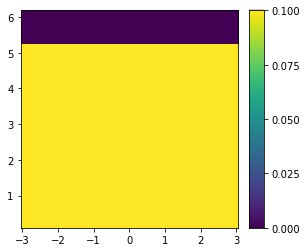

In [143]:
# A validation of acceleration term = g + pressure gradient
grid = contour_generator()
delta = 2*np.pi/32
gradient = (p[16,:,:]-p[14,:,:])/(2*delta)
acceleration = (ux[15,:,:]+0.5*ux[14,:,:]+0.5*ux[16,:,:]-2*np.average(ux))*0.5*0.1
image = np.rot90(acceleration)
image = gx[15,:,:]+gradient
xarray = x[:,0,0]; yarray = y[0,:,0]; zpoint = z[0,0,16]
pcontour = grid[0].imshow(image, extent=[xarray[0],xarray[-1],yarray[0],yarray[-1]])
# pcontour = grid[0].imshow(cs[:,:,20])
grid[0].cax.colorbar(pcontour)
# eta = -(-1.1 + 0.5*np.sin(xarray)*np.cos(zpoint*2))
# eta = np.ones(np.size(xarray))
# grid[0].plot(xarray, eta, color='k', linewidth=2)

In [ ]:
filename = "/home/jiarong/research/projects/LES/fflat_DNS/field_100"
data = pd.read_table(filename, delimiter = ',')
# Sort dataframe by y value, only taking the upper half, optional
data = data.sort_values(by = ['x','y','z'])
N=128; x,y,z,ux,uy,Evis,dudy = shape_input(N, data)
yarray, uxarray = profile(y,ux)
plt.plot(yarray, uxarray, label = 'DNS')
plt.plot(yarray, uxarray, '.', color=plt.gca().lines[-1].get_color())
filename = "/home/jiarong/research/projects/LES/fflat_LES/trial1/field_100"
data = pd.read_table(filename, delimiter = ',')
# Sort dataframe by y value, only taking the upper half, optional
data = data.sort_values(by = ['x','y','z'])
N=32; x,y,z,ux,uy,Evis,dudy = shape_input(N, data)
yarray, uxarray = profile(y,ux)
plt.plot(yarray, uxarray, label = '32 point')
plt.plot(yarray, uxarray, '.', color=plt.gca().lines[-1].get_color())
filename = "/home/jiarong/research/projects/LES/fflat_LES/trial6/field_100"
data = pd.read_table(filename, delimiter = ',')
# Sort dataframe by y value, only taking the upper half, optional
data = data.sort_values(by = ['x','y','z'])
N=16; x,y,z,ux,uy,Evis,dudy = shape_input(N, data)
yarray, uxarray = profile(y,ux)
plt.plot(yarray, uxarray, label = '16 point')
plt.plot(yarray, uxarray, '.', color=plt.gca().lines[-1].get_color())
plt.legend()
plt.xlabel('$\overline{U}$')
plt.ylabel('$z$')

In [ ]:
def profile(y,ux):
    uxarray = []
    yarray = y[0,:,0]
    for iy in range(0,np.size(yarray)):
        uxslice = ux[:,iy,:]
        uxarray.append(np.average(uxslice))
    return yarray, uxarray
filename = "/home/jiarong/research/projects/LES/fflat_LES/trial5/field_500"
data = pd.read_table(filename, delimiter = ',')
# Sort dataframe by y value, only taking the upper half, optional
data = data.sort_values(by = ['x','y','z'])
N=16; x,y,z,ux,uy,Evis,dudy = shape_input(N, data)
yarray, uxarray = profile(y,ux)
plt.plot(yarray, uxarray, '.', label = '16 grid point')
filename = "/home/jiarong/research/projects/LES/fflat_LES/trial3/field_500"
data = pd.read_table(filename, delimiter = ',')
# Sort dataframe by y value, only taking the upper half, optional
data = data.sort_values(by = ['x','y','z'])
N=32; x,y,z,ux,uy,Evis,dudy = shape_input(N, data)
yarray, uxarray = profile(y,ux)
plt.plot(yarray, uxarray, '.', label = '32 grid point')
filename = "/home/jiarong/research/projects/LES/fflat_LES/trial4/field_500"
data = pd.read_table(filename, delimiter = ',')
# Sort dataframe by y value, only taking the upper half, optional
data = data.sort_values(by = ['x','y','z'])
N=64; x,y,z,ux,uy,Evis,dudy = shape_input(N, data)
yarray, uxarray = profile(y,ux)
plt.plot(yarray, uxarray, '.', label = '64 grid point')
plt.legend(); plt.xlabel('z'); plt.ylabel('$\overline{U}$')

In [7]:
import psutil
psutil.virtual_memory()

svmem(total=16705527808, available=2879668224, percent=82.8, used=13107929088, free=2079858688, active=12344881152, inactive=1862520832, buffers=32849920, cached=1484890112, shared=389640192, slab=218542080)

In [12]:
# DNS instantanous velocity
slicei = np.arange(55,56)
ux_ensemble = []
slope_ensemble = []
import csv

for i in range(0,slicei.size):
    filename = "/home/jiarong/research/projects/turbulence/uniform_forcing_test/ux_t%g_slice%g" % (200,slicei)
    import os
    array2D = []
    with open(filename, 'r') as f:
        for line in f.readlines():
            array2D.append(line.split('\t'))
    #     data = np.loadtxt(filename, dtype=np.str, delimiter='\t')
#     with open(filename) as f:
        
#         reader = csv.reader(f, delimiter="\t")
#         data = np.asarray(reader)
#         d = list(reader)
#     ux = np.fromfile (filename, delimiter = '\t')
#     ux = np.reshape(ux, (128,128))
#     plt.imshow(ux)

4.368339334594254


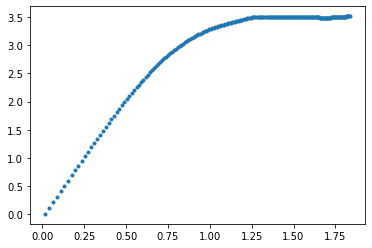

In [32]:
plt.plot(np.log(yarray[41:]), uxarray[41:], '.')
slope = (uxarray[50]-uxarray[41])/(np.log(yarray[50])-np.log(yarray[41]))
print(slope)

In [9]:
time_stamp = np.arange(400,1000,10)
ux_ensemble = []
slope_ensemble = []
for i in range(0,time_stamp.size):
    filename = "/home/jiarong/research/projects/LES/fflat_LES_withforcing/a001/field_%g" % time_stamp[i]
    snapshot = pd.read_table(filename, delimiter = ',')
    snapshot = snapshot.sort_values(by = ['x','y','z'])
    x,y,z,ux,uy,Evis,dudy,p,gx = shape_input(32,snapshot)
    uxarray = []
    yarray = y[0,:,0]
    for iy in range(0,np.size(yarray)):
        uxslice = ux[:,iy,:]
        uxarray.append(np.average(uxslice))
#     plt.plot(uxarray[5:], (yarray[5:]), label='t=%g' % time_stamp[i], color=plt.cm.get_cmap('summer')(1-i/time_stamp.size))
#     plt.plot(uxarray[5:], (yarray[5:]), '.', color=plt.gca().lines[-1].get_color())
#     plt.legend()
    ux_ensemble.append(uxarray)
    slope = (uxarray[6]-uxarray[5])/(np.log(yarray[6]/0.01)-np.log(yarray[5]/0.01)) 
    slope_ensemble.append(slope)
# plt.xlabel('$\overline{U}$')
# plt.ylabel('$z$')
ux_ensemble = np.array(ux_ensemble)
slope_ensemble = np.array(slope_ensemble)

Text(0.5, 0, '$\\bar{U}$')

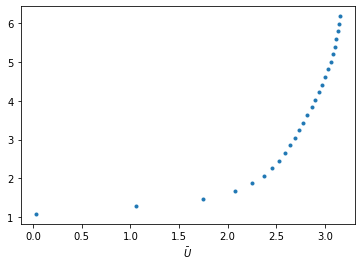

In [10]:
ux_aver = np.average(ux_ensemble, axis=0)
plt.plot(ux_aver[5:], yarray[5:], '.')
plt.xlabel(r'$\bar{U}$')

Text(0.5, 0, '$\\bar{U}$')

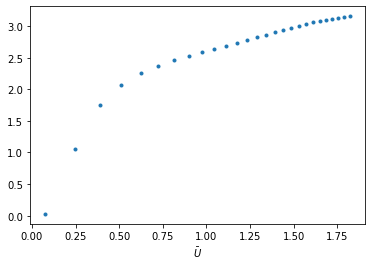

In [14]:
ux_aver = np.average(ux_ensemble, axis=0)
plt.plot(np.log(yarray[5:]),ux_aver[5:],'.')
plt.xlabel(r'$\bar{U}$')

In [18]:
np.log(10)

2.302585092994046

In [11]:
np.average(slope_ensemble)


6.162125853218513

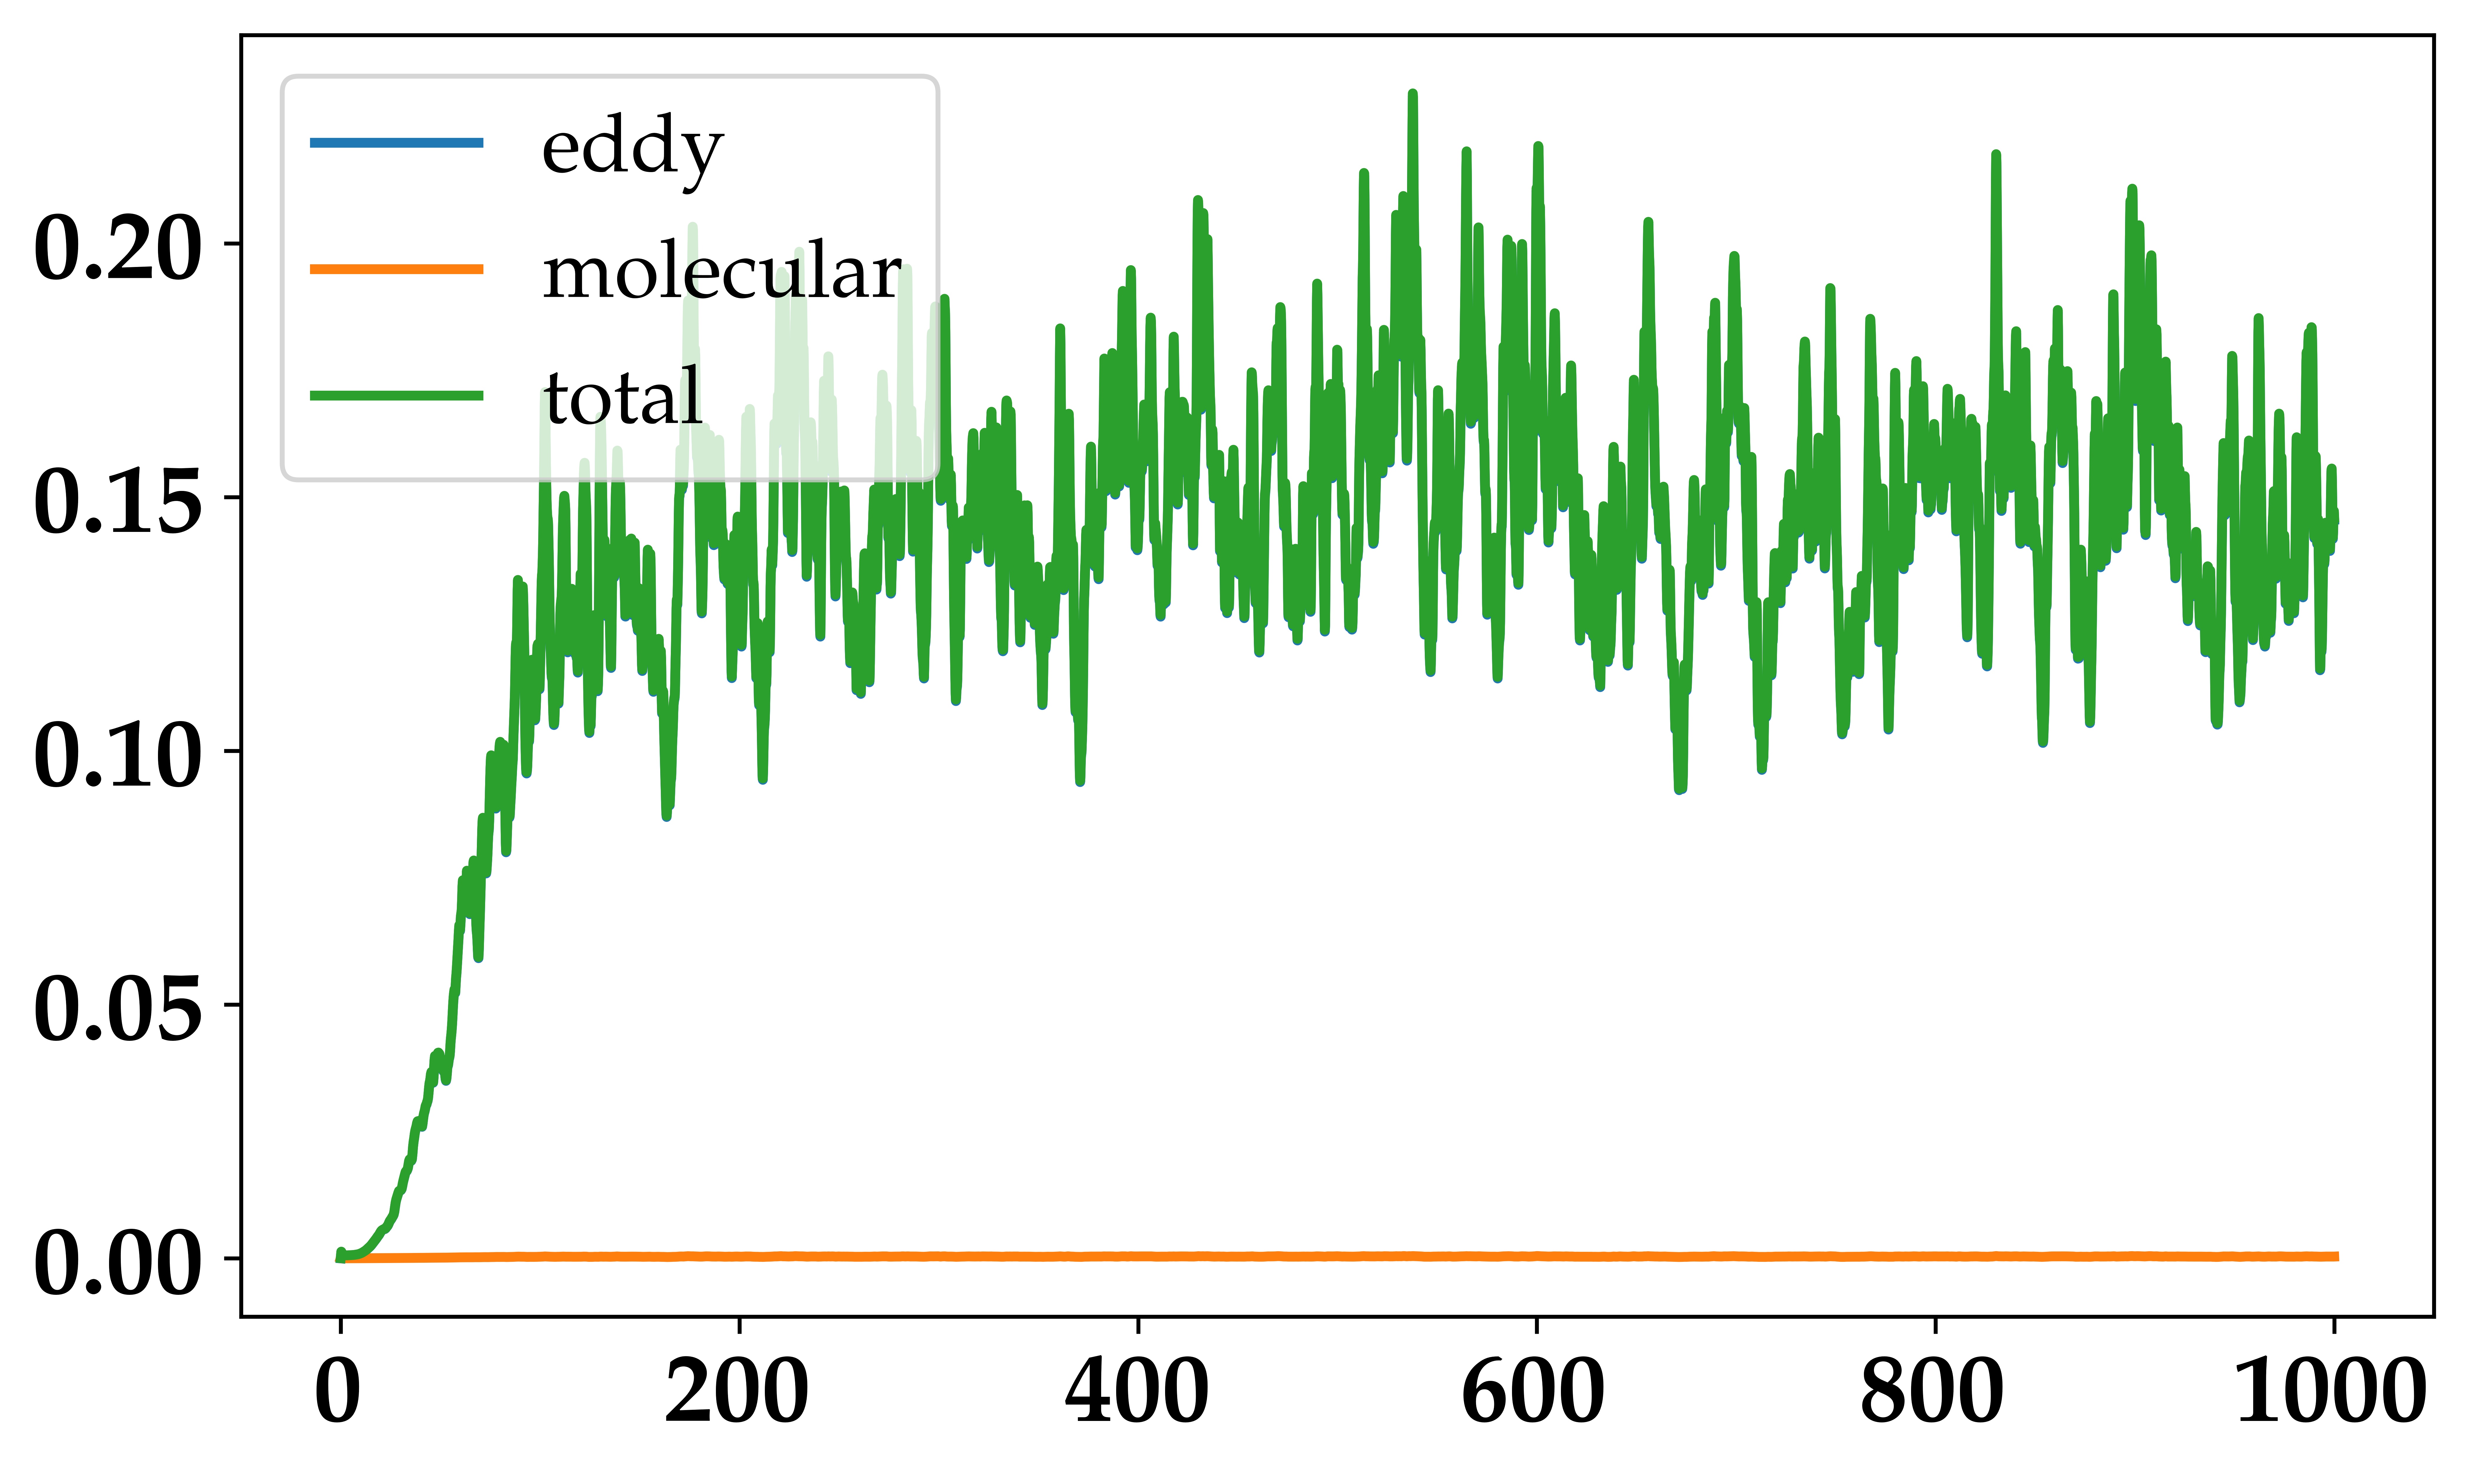

In [160]:
# Look at the dissipation
filename = "/home/jiarong/research/projects/LES/fflat_LES_withforcing/LES.dat"
stat = pd.read_table(filename, delimiter = ' ')
diss = np.array(stat.dissipationt)
energy = np.array(stat.energy)
diss_eddy = np.array(stat.disse)
diss_mol = np.array(stat.dissm)
plt.plot(stat.t, diss_eddy, label = 'eddy')
plt.plot(stat.t, diss_mol, label = 'molecular')
plt.plot(stat.t, diss, label = 'total')
plt.legend()

Text(0, 0.5, 'Turbulent Stress')

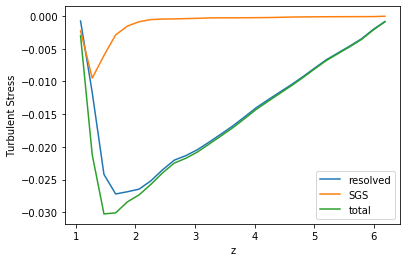

In [12]:
# Look at resolved fluxes and subgrid scale fluxes
# Average over a few snapshot?
time_stamp = np.arange(800,1000,10)
tau12_resolved_ensemble = []
tau12_subgrid_ensemble = []
for i in range(0,time_stamp.size):
    filename = "/home/jiarong/research/projects/LES/fflat_LES_withforcing/a001/field_%g" % time_stamp[i]
    data = pd.read_table(filename, delimiter = ',')
    data = data.sort_values(by = ['x','y','z'])
    x,y,z,ux,uy,Evis,dudy,p,gx = shape_input(32, data)
    tau12_resolved = []
    tau12_subgrid = []
    Evis_aver = []
    uxarray = []; uyarray = []
    yarray = y[0,:,0]
    for iy in range(0,np.size(yarray)):
        # Resolved part
        uxslice = ux[:,iy,:]; uyslice = uy[:,iy,:]
        uxarray.append(np.average(uxslice)); uyarray.append(np.average(uyslice))
        ux_fluc = uxslice - np.average(uxslice)
        uy_fluc = uyslice - np.average(uyslice)
        flux_resolved = np.average(ux_fluc*uy_fluc)
        tau12_resolved.append(flux_resolved)
        # Subgrid part
        Evisslice = Evis[:,iy,:]; dudyslice = dudy[:,iy,:]
        Evis_aver.append(np.average(Evisslice))
        flux_subgrid = np.average(-Evisslice*dudyslice)
        tau12_subgrid.append(flux_subgrid)
        tau12_resolved_ensemble.append(tau12_resolved)
        tau12_subgrid_ensemble.append(tau12_subgrid)        
tau12r_aver = np.average(np.array(tau12_resolved_ensemble), axis=0)
tau12s_aver = np.average(np.array(tau12_subgrid_ensemble), axis=0)
plt.plot(yarray[5:], tau12r_aver[5:], label='resolved')
plt.plot(yarray[5:], tau12s_aver[5:], label='SGS')
plt.plot(yarray[5:], tau12r_aver[5:]+tau12s_aver[5:], label='total')
plt.legend(); plt.xlabel('z'); plt.ylabel('Turbulent Stress')

Text(0, 0.5, 'Turbulent Stress')

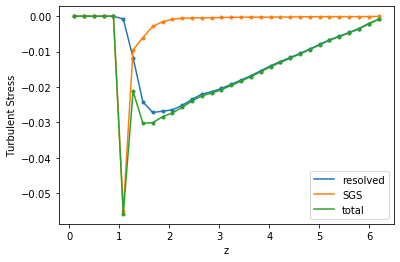

In [13]:
slope = np.average(slope_ensemble)
# tau_wall = (slope*0.4)**2
tau_wall = -0.01*(np.pi*2-1)
tau12s_aver[5] = tau12s_aver[5]+tau_wall
plt.plot(yarray, tau12r_aver, label='resolved')
plt.plot(yarray, tau12r_aver, '.', color = plt.gca().lines[-1].get_color())
plt.plot(yarray, tau12s_aver, label='SGS')
plt.plot(yarray, tau12s_aver, '.', color = plt.gca().lines[-1].get_color())
plt.plot(yarray, tau12r_aver+tau12s_aver, label='total')
plt.plot(yarray, tau12r_aver+tau12s_aver, '.', color = plt.gca().lines[-1].get_color())
plt.legend(); plt.xlabel('z'); plt.ylabel('Turbulent Stress')